# EDU RANK PREDICTION on THE

## Introduction

This notebook is a part of the project for the department of Data Management at Dokuz Eylul University. 




In [1]:

DATA_PATH = "../data/"
SRC_PATH = "../src/"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix
import sklearn.metrics as mt


In [3]:
# Load the data
data = pd.read_excel(DATA_PATH + "THE.xlsx")
data.dropna(subset=['rank'], inplace=True)

In [4]:
data.shape # 2092 rows and 29 columns


(2092, 29)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2092 entries, 0 to 2091
Data columns (total 29 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   rank_order                         2092 non-null   int64  
 1   rank                               2092 non-null   object 
 2   name                               2092 non-null   object 
 3   scores_overall                     2092 non-null   object 
 4   scores_overall_rank                2092 non-null   int64  
 5   scores_teaching                    2092 non-null   float64
 6   scores_teaching_rank               2092 non-null   int64  
 7   scores_research                    2092 non-null   float64
 8   scores_research_rank               2092 non-null   int64  
 9   scores_citations                   2092 non-null   float64
 10  scores_citations_rank              2092 non-null   int64  
 11  scores_industry_income             2092 non-null   float64
 1

In [6]:
data.isnull().sum()

rank_order                            0
rank                                  0
name                                  0
scores_overall                        0
scores_overall_rank                   0
scores_teaching                       0
scores_teaching_rank                  0
scores_research                       0
scores_research_rank                  0
scores_citations                      0
scores_citations_rank                 0
scores_industry_income                0
scores_industry_income_rank           0
scores_international_outlook          0
scores_international_outlook_rank     0
record_type                           0
member_level                          0
url                                   0
nid                                   0
location                              0
stats_number_students                 0
stats_student_staff_ratio             0
stats_pc_intl_students                0
stats_female_male_ratio              81
aliases                               0


In [7]:
#data.loc[data['closed'] == 1] No closed universities
data.drop('closed', axis=1, inplace=True)

In [8]:
data['rank'].value_counts() 

rank
1501+        591
1201–1500    302
601–800      203
1001–1200    200
801–1000     195
            ... 
44             1
43             1
42             1
41             1
89             1
Name: count, Length: 142, dtype: int64

In [9]:
data['rank'] = data['rank'].astype(str)
data['stats_number_students'] = data['stats_number_students'].str.replace(',', '').astype(float)
data.sort_values('rank_order', inplace=True)
data.reset_index(drop=True, inplace=True)

In [10]:
# Ensure 'rank_order' is numeric

# Function to categorize rank values
def categorize_rank(rank):
    if pd.isna(rank):
        return None
    elif rank <= 3000:
        return '1-300'
    elif rank <= 4000:
        return '301-400'
    elif rank <= 7000:
        return '401-700'
    elif rank <= 9000:
        return '701-900'
    elif rank <= 11000:
        return '901-1100'
    elif rank <= 12000:
        return '1101-1200'
    elif rank <= 13000:
        return '1201-1300'
    elif rank <= 14000:
        return '1301-1400'
    elif rank <= 15000:
        return '1401-1500'
    elif rank <= 16000:
        return '1501-1600'
    elif rank <= 17000:
        return '1601-1700'
    elif rank  <= 18000:
        return '1701-1800'
    elif rank >= 18001:
        return '1801+'
    

# Apply the function to create the 'label' column
data['label'] = data['rank_order'].apply(categorize_rank)
target = data['label']
data.drop(columns=['rank','name','url','aliases','unaccredited'], inplace=True)

In [11]:
data['label'].value_counts()

label
1-300        300
401-700      300
1801+        292
701-900      200
901-1100     200
301-400      100
1101-1200    100
1201-1300    100
1301-1400    100
1401-1500    100
1501-1600    100
1601-1700    100
1701-1800    100
Name: count, dtype: int64

In [12]:
data['scores_overall'] = data['scores_overall'].str.split('–').str[0].astype(float)


In [13]:
data[['rank_order','member_level']].corr()

,rank_order,member_level
rank_order,1.000000,-0.231823
member_level,-0.231823,1.000000


In [14]:
data['location'].value_counts() 

location
United States     174
Japan             119
United Kingdom    107
India             107
China              94
                 ... 
Luxembourg          1
Palestine           1
Bahrain             1
Oman                1
Armenia             1
Name: count, Length: 115, dtype: int64

In [15]:
# location if country count less than 10, convert to 'Other'
country_count = data['location'].value_counts()
data['location'] = data['location'].apply(lambda x: 'Other' if country_count[x] < 4 else x)
data.loc[data['location'] == 'Other']

,rank_order,scores_overall,scores_overall_rank,scores_teaching,scores_teaching_rank,scores_research,scores_research_rank,scores_citations,scores_citations_rank,scores_industry_income,...,member_level,nid,location,stats_number_students,stats_student_staff_ratio,stats_pc_intl_students,stats_female_male_ratio,subjects_offered,disabled,label
16,170,89.9,170,78.4,24,93.6,15,95.7,41,100.0,...,6,504,Other,34388.0,21.0,26%,49 : 51,"Computer Science,Chemistry,Economics & Econome...",False,1-300
29,300,81.8,300,65.8,51,79.3,30,94.5,54,99.9,...,6,634,Other,26044.0,17.1,29%,48 : 52,"Psychology,Geology, Environmental, Earth & Mar...",False,1-300
180,1810,59.7,1810,37.7,377,39.0,274,90.7,104,70.4,...,11,1027,Other,11573.0,19.2,46%,54 : 46,"General Engineering,Communication & Media Stud...",False,1-300
219,2200,55.8,2200,31.0,693,37.4,302,87.5,171,69.0,...,0,131534,Other,9701.0,8.5,36%,NaN,"Law,Languages, Literature & Linguistics,Civil ...",False,1-300
237,2380,55.8,2380,39.2,333,39.5,261,77.1,401,81.3,...,0,131698,Other,5860.0,22.1,52%,54 : 46,"Computer Science,Physics & Astronomy,Economics...",False,1-300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2040,20410,10.5,20410,20.2,1481,11.2,1627,20.8,1825,26.6,...,0,677010,Other,22458.0,13.5,4%,65 : 35,"Sport Science,Economics & Econometrics,Mathema...",False,1801+
2053,20540,10.5,20540,20.7,1444,8.8,1991,10.5,2022,24.0,...,0,131353,Other,20855.0,10.9,1%,60 : 40,"Medicine & Dentistry,Geology, Environmental, E...",False,1801+
2064,20650,10.5,20650,15.1,1901,9.9,1824,29.2,1613,21.4,...,0,670626,Other,23677.0,26.9,2%,40 : 60,"Archaeology,Mechanical & Aerospace Engineering...",False,1801+
2066,20670,10.5,20670,14.2,1950,10.6,1711,39.3,1361,21.0,...,0,707981,Other,23476.0,18.3,0%,51 : 49,"General Engineering,Mathematics & Statistics,L...",False,1801+


In [16]:
data['location'].value_counts(  )

location
United States     174
Japan             119
United Kingdom    107
India             107
China              94
                 ... 
Cyprus              4
Latvia              4
Kazakhstan          4
Bulgaria            4
Slovenia            4
Name: count, Length: 70, dtype: int64

In [17]:
data['subjects_offered length'] = data['subjects_offered'].str.split(',').str.len()
data.drop('subjects_offered', axis=1, inplace=True)

In [18]:
data['stats_pc_intl_students'] = data['stats_pc_intl_students'].str.replace('%', '').astype(float) / 100
data['stats_female_ratio'] = data['stats_female_male_ratio'].str.split(':').str[0].astype(float) / 100
data.drop('stats_female_male_ratio' , axis=1, inplace=True)
data['stats_female_ratio'].fillna(data['stats_female_ratio'].mean(), inplace=True)

C:\Users\firat\AppData\Local\Temp\ipykernel_8144\178292832.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['stats_female_ratio'].fillna(data['stats_female_ratio'].mean(), inplace=True)


In [19]:
data.isnull().sum()

rank_order                           0
scores_overall                       0
scores_overall_rank                  0
scores_teaching                      0
scores_teaching_rank                 0
scores_research                      0
scores_research_rank                 0
scores_citations                     0
scores_citations_rank                0
scores_industry_income               0
scores_industry_income_rank          0
scores_international_outlook         0
scores_international_outlook_rank    0
record_type                          0
member_level                         0
nid                                  0
location                             0
stats_number_students                0
stats_student_staff_ratio            0
stats_pc_intl_students               0
disabled                             0
label                                0
subjects_offered length              0
stats_female_ratio                   0
dtype: int64

In [20]:
data = data[[ 'location', 'stats_number_students', 'stats_pc_intl_students', 'stats_student_staff_ratio','scores_teaching', 'scores_research', 'scores_citations', 'scores_industry_income', 'scores_international_outlook','member_level','subjects_offered length','record_type','disabled']]


In [21]:
# Ensure datetime columns are converted to a suitable string format
datetime_columns = data.select_dtypes(include=['datetime']).columns
for col in datetime_columns:
    data[col] = pd.to_datetime(data[col]).dt.strftime('%Y-%m-%d')

# Identify categorical columns
categorical_columns = data.select_dtypes(include=['object']).columns

# Get the indices of categorical columns
categorical_features = [data.columns.get_loc(c) for c in categorical_columns]

# Apply SMOTE-NC
smote_nc = SMOTENC(categorical_features=categorical_features, random_state=42, k_neighbors=5, n_jobs=-1)

# Convert categorical columns to 'category' dtype
for col in categorical_columns:
    data[col] = data[col].astype('category')

# Perform oversampling with SMOTE-NC with new 1000 samples
data_resampled, target_resampled = smote_nc.fit_resample(data, target)


print(f"Previous class distribution: {dict(pd.Series(target).value_counts())}")
print(f"New class distribution: {dict(pd.Series(target_resampled).value_counts())}")

C:\Users\firat\anaconda3\Lib\site-packages\imblearn\over_sampling\_smote\base.py:619: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
C:\Users\firat\anaconda3\Lib\site-packages\imblearn\over_sampling\_smote\base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Previous class distribution: {'1-300': 300, '401-700': 300, '1801+': 292, '701-900': 200, '901-1100': 200, '301-400': 100, '1101-1200': 100, '1201-1300': 100, '1301-1400': 100, '1401-1500': 100, '1501-1600': 100, '1601-1700': 100, '1701-1800': 100}
New class distribution: {'1-300': 300, '301-400': 300, '401-700': 300, '701-900': 300, '901-1100': 300, '1101-1200': 300, '1201-1300': 300, '1301-1400': 300, '1401-1500': 300, '1501-1600': 300, '1601-1700': 300, '1701-1800': 300, '1801+': 300}


# Model Building

In [22]:
# Label encoding
dummy = ['member_level', 'record_type', 'disabled']
label_en = 'location'

label_encoder = LabelEncoder()
data_resampled[label_en] = label_encoder.fit_transform(data_resampled['location'])

# One-hot encoding
one_hot = OneHotEncoder(sparse=False)
one_hot_encoded = one_hot.fit_transform(data_resampled[dummy])

# Create a DataFrame from the one-hot encoded array
one_hot_df = pd.DataFrame(one_hot_encoded, columns=one_hot.get_feature_names_out(dummy))

# Concatenate the one-hot encoded DataFrame with the original DataFrame
data_resampled = pd.concat([data_resampled, one_hot_df], axis=1)

# Drop the original columns that were one-hot encoded
data_resampled.drop(columns=dummy, inplace=True)

C:\Users\firat\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [23]:
X_train, X_test, y_train, y_test = train_test_split(data_resampled, target_resampled, test_size=0.3, random_state=42,stratify=target_resampled)




In [24]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape



((2730, 27), (1170, 27), (2730,), (1170,))

In [25]:
# Convert all columns to numeric, coercing errors to NaN
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

# Fill NaN values with a specific value or handle them as needed
X_train.fillna(0, inplace=True)  # Example: filling NaN with 0
X_test.fillna(0, inplace=True)   # Example: filling NaN with 0


In [26]:
# Model training and evaluation
models = {
    'Gradient Boosting': GradientBoostingClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(),
    'Support Vector Machine': SVC(kernel='rbf', C=1e5, gamma='auto')
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{name} Accuracy: {mt.accuracy_score(y_test, y_pred)}")

Gradient Boosting Accuracy: 0.6452991452991453
Random Forest Accuracy: 0.7282051282051282
Decision Tree Accuracy: 0.5854700854700855
K-Nearest Neighbors Accuracy: 0.2675213675213675
Naive Bayes Accuracy: 0.4427350427350427


C:\Users\firat\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.24358974358974358
Support Vector Machine Accuracy: 0.13418803418803418


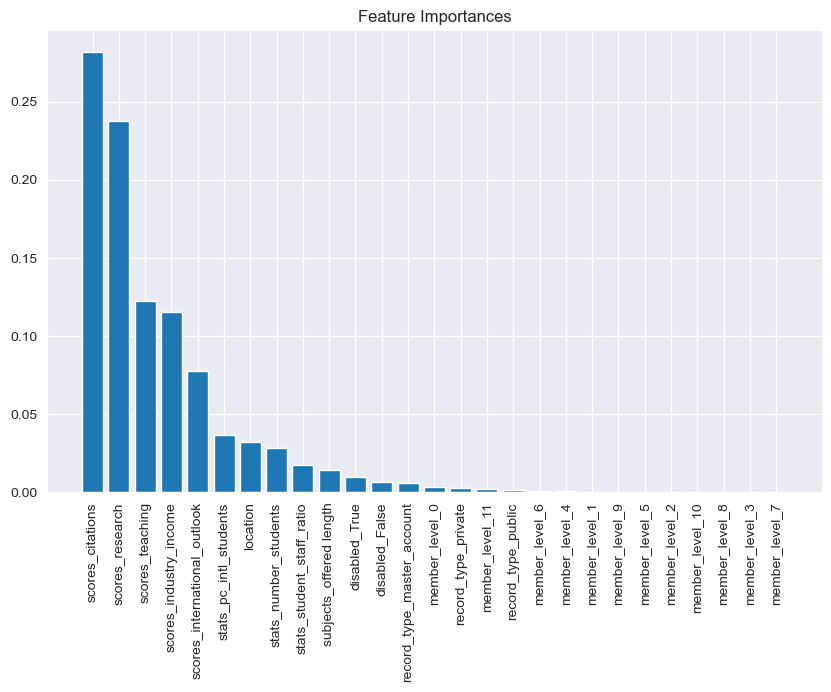

In [27]:
# Feature Importance

model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=5)
model.fit(X_train, y_train)
mt.accuracy_score(y_test, model.predict(X_test))

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_train.columns

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), [features[i] for i in indices], rotation=90)

plt.show()


In [28]:
# Hyperparameter Tuning


# Create the parameter grid based on the results of random search
'''
param_grid = {
    'bootstrap': [True],
    'max_depth': [50,100],
    'max_features': [6,7,8],
    'min_samples_leaf': [2,3],
    'min_samples_split': [6,8],
    'n_estimators': [800,1000]
}

# Create a based model
rf = RandomForestClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, verbose = 2, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

grid_search.best_params_
'''



"\nparam_grid = {\n    'bootstrap': [True],\n    'max_depth': [50,100],\n    'max_features': [6,7,8],\n    'min_samples_leaf': [2,3],\n    'min_samples_split': [6,8],\n    'n_estimators': [800,1000]\n}\n\n# Create a based model\nrf = RandomForestClassifier()\n\n# Instantiate the grid search model\ngrid_search = GridSearchCV(estimator = rf, param_grid = param_grid, \n                          cv = 3, verbose = 2, scoring='accuracy')\n\n# Fit the grid search to the data\ngrid_search.fit(X_train, y_train)\n\ngrid_search.best_params_\n"

In [29]:


param = {
    'n_estimators': 1000,
    'min_samples_split': 4,
    'min_samples_leaf': 2,
    'max_features': 8,
    'max_depth': 100,
    'bootstrap': True,
    'random_state': 42,
    'verbose': 1,
    'class_weight': 'balanced'
}


In [41]:

model = RandomForestClassifier(**param)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mt.accuracy_score(y_test, y_pred),mt.f1_score(y_test, y_pred, average='weighted')


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    8.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished


0.7277408663084513

In [36]:
sorted_labels = [
    '1-300', '301-400', '401-700', '701-900', '901-1100', '1101-1200',
    '1201-1300', '1301-1400', '1401-1500', '1501-1600', '1601-1700',
    '1701-1800', '1801+'
]

# Generate the classification report with sorted labels
report = classification_report(y_test, y_pred, labels=sorted_labels)
print(report)

              precision    recall  f1-score   support

       1-300       0.96      0.94      0.95        90
     301-400       0.84      0.90      0.87        90
     401-700       0.74      0.66      0.69        90
     701-900       0.64      0.68      0.66        90
    901-1100       0.67      0.60      0.63        90
   1101-1200       0.75      0.84      0.79        90
   1201-1300       0.78      0.62      0.69        90
   1301-1400       0.69      0.71      0.70        90
   1401-1500       0.65      0.82      0.73        90
   1501-1600       0.76      0.72      0.74        90
   1601-1700       0.70      0.68      0.69        90
   1701-1800       0.74      0.71      0.72        90
       1801+       0.60      0.59      0.59        90

    accuracy                           0.73      1170
   macro avg       0.73      0.73      0.73      1170
weighted avg       0.73      0.73      0.73      1170



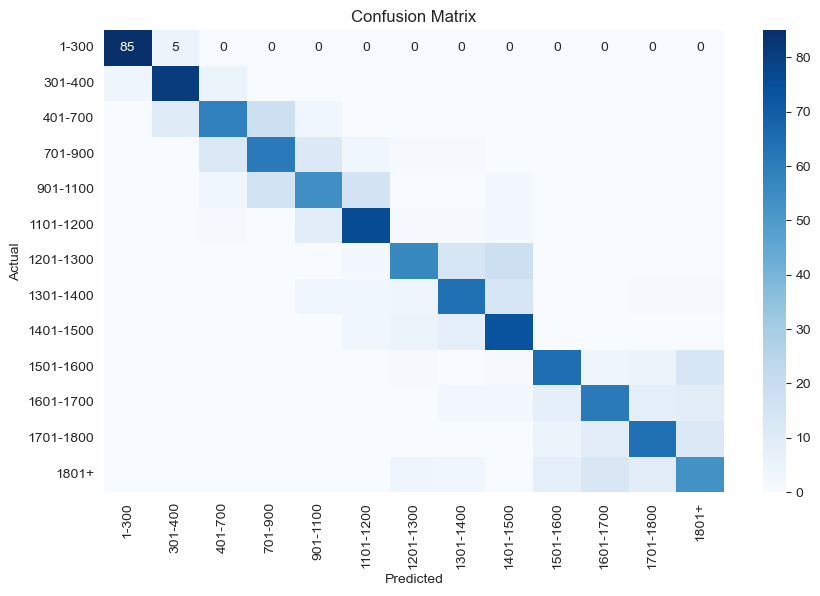

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=sorted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted_labels, yticklabels=sorted_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()